# Homework 3 Part 2 - Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# Problem 1 (10 points)

**In this data you will working with the [Wine Dataset](https://archive.ics.uci.edu/ml/datasets/wine):**

In [2]:
from sklearn.datasets import load_wine
wine = load_wine(return_X_y=False)
# print(wine.DESCR)

**Let's load this data into a ```pandas``` dataframe:**

In [3]:
import pandas as pd

df = pd.DataFrame(np.hstack((wine.target[:,np.newaxis],wine.data)), columns=['Class']+wine.feature_names)
df

,Class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,0.0,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,0.0,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,0.0,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,0.0,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,2.0,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,2.0,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,2.0,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,2.0,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


**Answer the following questions:**

1. **Implement k-Means for the 13 wine features. Use the silhouette index to determine which value of $k$ best works for this data. Justify your answer.**

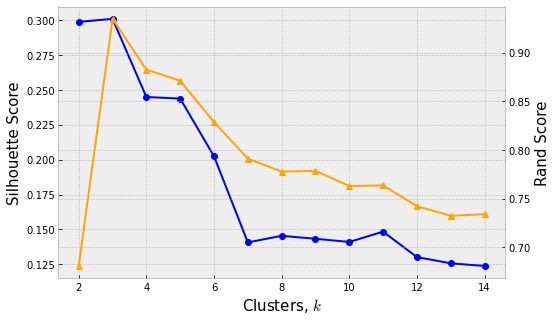

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score

## Loading data and Standardization
X = df[df.columns[1:]].to_numpy() # Training Data
scaler = MinMaxScaler() # Scaling data using standardization
X_scaled = scaler.fit_transform(X)

## Routine to determine which k value works best for each criteria
ss = [] # silhouette score
rs = [] # rand score
for k in range(2,15):
    labels = KMeans(k,random_state=1).fit_predict(X_scaled) # Training K-Means
    ss+=[silhouette_score(X_scaled, labels)] #appending silhouette score for clustering results
    rs+=[rand_score(wine.target, labels)] #appending rand score for clustering results

## Plotting results
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(range(2,15), ss,'-ob', label='Silhouette Score')
ax.set_xlabel('Clusters, $k$',size=15); ax.set_ylabel('Silhouette Score',size=15)
ax2=ax.twinx(); ax2.plot(range(2,15), rs, '-^',color='orange', label='Rand Score')
ax2.set_ylabel('Rand Score',size=15);

As seen from the plot above, the best value of $k$ according to the Silhouette index is $k=3$. (Different partitions of the data or different random seeds may change the results.)

Since we know the number of classes in the training data (3 different types of wine) and their correspondent labels, it is not surprising that the best value for $k$ is for $k=3$. However, the rand score is not 1 for $k=3$, indicating that K-Means with Euclidean distance has difficulty in grouping some samples.

2. **For the *optimal* value of $k$ found in the previous question, predict the clustering labels. Compute the rand index for these estimated labels vs the true labels.**

In [5]:
# Training the final clustering algorithms (with the nest returned k value)

labels = KMeans(3).fit_predict(X_scaled)

In [6]:
# Computing the rand score

print('Silhouette Score: ', silhouette_score(X_scaled, labels)) 

print('Rand Score: ', rand_score(wine.target, labels)) 

Silhouette Score:  0.3013463273503232
Rand Score:  0.941471465752555


Moreover, from the silhouette score, we can see that the formed clusters are do not satisfy at least one of the silhouette score conditions for compactness and separability.

# Problem 2 (10 points)

**Build a Python function to implement the $k$-Nearest Neighbors ($k$-NN) algorithm using Euclidean distance.**

* **You should code this function on your own.**
* **You are allowed to use any needed functions from ```numpy```.**

In [7]:
from scipy.spatial.distance import cdist
import numpy.matlib

In [8]:
def kNN(X_train,y_train,X_test,k):
    '''This function implements k-Nearest Neighbors
    Given same training data examples, k-NN classifies the points in the
    test set using some pre-determined number of neighbors k.
    This implementation uses non-weighted k-NN with Euclidean distance,
    majority vote and a simple tie-breaker strategy.'''
    
    # Compute the Euclidean distance to each test point to the training samples
    D = cdist(X_train, X_test, metric='Euclidean') # Matrix of size Ntrain x Ntest
    
    # Sort the distances (ascendent order)
    # Retrieve the index locations of the sorting operator
    sortedD_indexlocations = np.argsort(D, axis=0) # Matrix of size Ntrain x Ntest
    
    # Select the first K closest locations
    neigh_iloc = sortedD_indexlocations[:k,:] # Matrix of size k x Ntest
    
    # Identify the labels associated with the k neighbors
    neigh_labels = y_train[neigh_iloc] # Matrix of size k x Ntest
    
    # Majority Vote and Tie-Breaker Assignment
    Ntest = len(X_test)
    test_labels = []
    # For each test point
    for i in range(Ntest):
        # Find the unique labels for the k neighbors and count them
        # vals contains unique values
        # counts contains its correspondent counts
        vals, counts = np.unique(neigh_labels[:,i], return_counts=True)
        
        # We look to assign labels for which counts is maximized 
        #(most neighbors with that label)
        idx_label = np.where(counts==np.max(counts))
        
        # But there could be a tie
        if len(idx_label) > 1:
            # It tie, assign to test point to the label of the closest neighbor
            test_labels += [neigh_labels[0,i]]
        else:
            # if not, assign using majority vote
            test_labels += [vals[idx_label[0][0]]]
    return test_labels

# Problem 3 (15 points)

**In this problem you will be working with Breast cancer wisconsin (diagnostic) dataset from the UCI ML repository, also available in ```scikit-learn```. Let's load the data:**

In [9]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer(return_X_y=False)

# print(dataset.DESCR)

**For this problem, you will only be working with the radius and texture features:**

In [10]:
X = dataset.data[:,:2]
y = dataset.target

**Answer the following questions:**

1. **Partition the data into training and test using 70/30 partition, respectively.**

2. **Train a Naive Bayes Classifier using the training data. Using the test data, evaluate the classifier performance using accuracy and confusion matrix.**

3. **Train a $k$-NN classifier with $k=3$ using the training data. Using the test data, evaluate the classifier performance using accuracy and confusion matrix.**

4. **From the results you obtained in 2 and 3, which model performs best? Explain your reasoning.**

5. **Implement 4-fold cross-validation to find out the best value of $k$ that maximizes the model's accuracy.**

**Utils:**
* **You can use the functions ```confusion_matrix``` and ```accuracy_score``` from the module ```sklearn.metrics```.**
* **You can use the functions ```train_test_split``` and ```KFold``` from the module ```sklearn.model_selection```.**

In [11]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score

First step is to standardize the data, as $k$-NN is heavily impacted by feature scalings.

In [12]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

Split the data into training and test using 70/30 partition:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((398, 2), (171, 2), (398,), (171,))

### Naive Bayes Classifier

In [14]:
# Prior probabilities
pC0 = np.sum(y_train==0)/y_train.size
pC1 = np.sum(y_train==1)/y_train.size

pC0, pC1

(0.3743718592964824, 0.6256281407035176)

In [15]:
# Means and covariances of the data likelihood
mu0 = np.mean(X_train[y_train==0,:],axis=0)
mu1 = np.mean(X_train[y_train==1,:],axis=0)

cov0 = np.cov(X_train[y_train==0,:].T)
cov1 = np.cov(X_train[y_train==1,:].T)

In [16]:
from scipy.stats import multivariate_normal

# Training Data Likelihood
y0_train = multivariate_normal.pdf(X_train, mean=mu0, cov=cov0) #P(x|C0)
y1_train = multivariate_normal.pdf(X_train, mean=mu1, cov=cov1) #P(x|C1)

# Test Data Likelihood
y0_test = multivariate_normal.pdf(X_test, mean=mu0, cov=cov0) #P(x|C0)
y1_test = multivariate_normal.pdf(X_test, mean=mu1, cov=cov1) #P(x|C1)

In [17]:
# Training Data Posterior
pos0_train = (y0_train*pC0)/(y0_train*pC0 + y1_train*pC1)
pos1_train = (y1_train*pC1)/(y0_train*pC0 + y1_train*pC1)
pos_train = np.array([pos0_train, pos1_train]).T
likelihood_train = np.array([y0_train, y1_train]).T

# Test Data Posterior
pos0_test = (y0_test*pC0)/(y0_test*pC0 + y1_test*pC1)
pos1_test = (y1_test*pC1)/(y0_test*pC0 + y1_test*pC1)
pos_test = np.array([pos0_test, pos1_test]).T
likelihood_test = np.array([y0_test, y1_test]).T

In [18]:
predict_train = []
predict_test  = []
likelihood_labels_train = []
likelihood_labels_test  = []
for i in range(pos_test.shape[0]):
    predict_test  += [np.where(pos_test[i,:]==pos_test[i,:].max())[0][0]]
    likelihood_labels_test  += [likelihood_test[np.where(pos_test[i,:]==pos_test[i,:].max())[0][0]]]

for i in range(pos_train.shape[0]):
    predict_train += [np.where(pos_train[i,:]==pos_train[i,:].max())[0][0]]
    likelihood_labels_train += [likelihood_train[np.where(pos_train[i,:]==pos_train[i,:].max())[0][0]]]

In [19]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix in Training')
print(confusion_matrix(y_train, predict_train))
print('Accuracy Score in training: ',accuracy_score(y_train, predict_train)*100,'%\n')

print('Confusion matrix in Test')
print(confusion_matrix(y_test, predict_test))
print('Accuracy Score in test: ',accuracy_score(y_test, predict_test)*100,'%\n')

Confusion matrix in Training
[[113  36]
 [ 11 238]]
Accuracy Score in training:  88.19095477386935 %

Confusion matrix in Test
[[ 50  13]
 [  4 104]]
Accuracy Score in test:  90.05847953216374 %



### $k$-NN Algorithm

In [20]:
pred_test = kNN(X_train, y_train, X_test, 3)

print('Confusion matrix in Test')
print(confusion_matrix(y_test, pred_test))
print('Accuracy Score in training: ',accuracy_score(y_test, pred_test)*100,'%\n')

Confusion matrix in Test
[[ 50  13]
 [  8 100]]
Accuracy Score in training:  87.71929824561403 %



The Naive Bayes performs slightly better with 90% accuracy when compared to 87.7% accuracy for $k$-NN in the test set.

### 4-Fold Cross-Validation to find the best parameter $k$ in $k$-NN

The k value chosen is  25 , with an average r2 score of  89.94444444444444 %


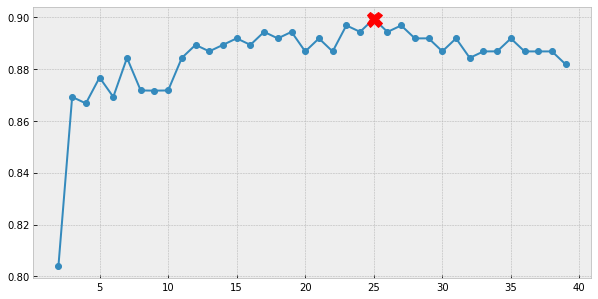

In [21]:
# 4-fold cross validation to find the best lambda value
kf = KFold(n_splits=4) # build the 4-fold CV object
k_vals = np.arange(2,40,1) # range of values for k

# Utility variables
max_a2 = 0
kk = 0
acc_fold=[]

# For every k value
for k in k_vals:
    a2_val = 0
    f=1
    # Split training data into training and validation sets
    for train_index, validation_index in kf.split(X_train):
        # Training set
        x_train2, x_validation = X_train[train_index,:], X_train[validation_index,:]
        #Validation set
        y_train2, y_validation = y_train[train_index], y_train[validation_index]
        # predict test labels using the k-NN function
        pred_val = kNN(x_train2, y_train2, x_validation, k)
        # Accuracy score for the validation set
        a2_val += accuracy_score(y_validation, pred_val)
    # Average the accuracy score for the 4 validation scores
    acc_fold += [a2_val/4]
    # keep the value for k with the largest average accuracy score
    if (a2_val/4 > max_a2):
        kk = k
        max_a2 = a2_val/4

print('The k value chosen is ', kk,', with an average r2 score of ', max_a2*100,'%')

plt.figure(figsize=(10,5))
plt.plot(k_vals, acc_fold,'-o')
plt.plot(kk,max_a2,'Xr',markersize=15);

The best value of $k$, given this training and test split, is $k=25$ with 89.9% accuracy.

In [22]:
# "Training" the final model with k=25 using all the training data

pred_test = kNN(X_train, y_train, X_test, 25)

print('Confusion matrix in Test')
print(confusion_matrix(y_test, pred_test))
print('Accuracy Score in training: ',accuracy_score(y_test, pred_test)*100,'%\n')

Confusion matrix in Test
[[ 52  11]
 [  5 103]]
Accuracy Score in training:  90.64327485380117 %



This final model is more competitive with the Naive Bayes, returning approximately the same accuracy score.

# Problem 4 (10 points)

**Consider the following data in a 2-dimensional feature space, $x_1$ and $x_2$, and its corresponding labels, $t$:**

|$x_1$|$x_2$|$t$|
|--|--|--|
|0|0|0|
|0.1|0|0|
|-0.1|0.1|0|
|0.05|0.1|0|
|-0.1|0|0|
|0.05|-0.1|0|
|1|1|1|
|1.2|0.9|1|
|0.9|1.1|1|
|0.8|0.9|1|
|2|1|1|
|1.5|0.9|1|

**Answer the following questions:**

1. **Find the Fisher's linear discriminant function. Specify all the parameters of the discriminant.**

2. **Find the Perceptron linear discriminant function. Specify all the parameters of the discriminant as well as the Perceptron diagram.**

3. **Discuss on whether any one of these solutions are *optimal*.**

(Computational and analytical answers will be accepted equally.)

In [23]:
# Code from Lecture 27

def fisherDiscriminant(data,t):
    '''This funciton implement the Fisher's LDA
    for a 2-class problem in a 2-D input space.'''
    data1 = data[t==0,:]
    data2 = data[t==1,:]
    mean1 = np.atleast_2d(np.mean(data1,0))
    mean2 = np.atleast_2d(np.mean(data2,0))
    Sw1 = np.dstack([(data1[i,:]-mean1).T@(data1[i,:]-mean1) for i in range(data1.shape[0])])
    Sw2 = np.dstack([(data2[i,:]-mean2).T@(data2[i,:]-mean2) for i in range(data2.shape[0])])
    Sw = np.sum(Sw1,2) + np.sum(Sw2,2)
    w = np.linalg.inv(Sw)@(mean2 - mean1).T
    w = w/np.linalg.norm(w)
    data_t = data@w
    return w, data_t

def discriminant(data, labels, v):
    v_perp = np.array([v[1], -v[0]])
    b = ((np.mean(data[labels==0,:],axis=0)+np.mean(data[labels==1,:],axis=0))/2)@v
    lambda_vec = np.linspace(-3,1,100)
    decision_boundary = b * v + lambda_vec * v_perp
    return b, v_perp, decision_boundary

In [24]:
# Provided data

X = np.array([[0,0],[0.1,0],[-0.1,0.1],[0.05,0.1],[-0.1,0],[0.05,-0.1],
              [1,1],[1.2,0.9],[0.9,1.1],[0.8,0.9],[2,1],[1.5,0.9]])

labels = np.array([0]*6+[1]*6)

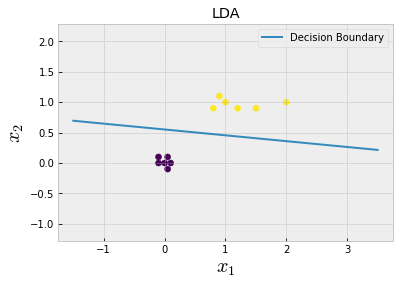

In [25]:
v, Y = fisherDiscriminant(X,labels)

fig = plt.figure()
plt.scatter(X[:,0],X[:,1],c=labels)

b, w, decision_boundary = discriminant(X, labels, v);
# plt.plot(decision_boundary[0,:], decision_boundary[1,:],'b',linewidth=2, label='Decision Boundary')
xrange=np.linspace(-1.5,3.5,100)
plt.plot(xrange, (xrange*w[1]+b)/w[0], label='Decision Boundary')
plt.title('LDA'); plt.axis('equal'); plt.legend(loc='best')
plt.xlabel('$x_1$',size=20); plt.ylabel('$x_2$',size=20);

In [26]:
print('Bias term:' ,b)
print('Coefficients: ',w)

Bias term: [0.54826431]
Coefficients:  [[ 0.99543731]
 [-0.09541778]]


So the discriminant function line can be written as:

$$y(x_1,x_2) = -0.0954 x_1 +  0.9954 x_2 + 0.5483$$

The associated diagram can be drawn as:

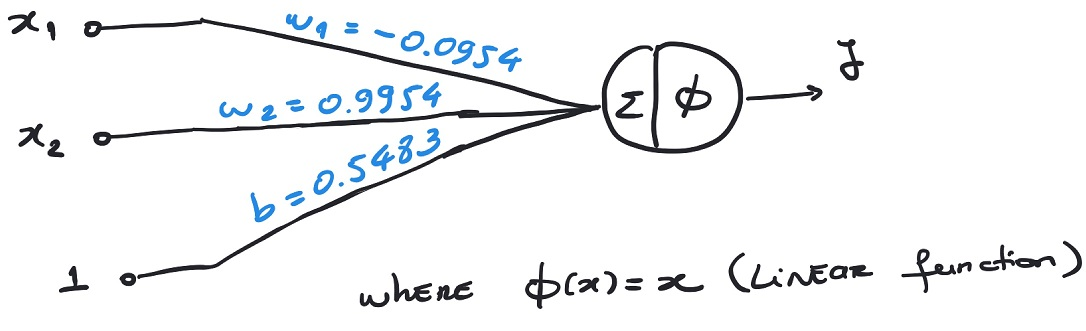

In [27]:
from IPython.display import Image
Image('Q4-1.jpg',width=600)

The LDA discriminant function is **unique**, that is, it is a global solution for this particular dataset.

For the perceptron, we know that *a* line that linearly separates the two classes without error will be an acceptable solution. So we can consider any line without any misclassification error. Consider the one below:

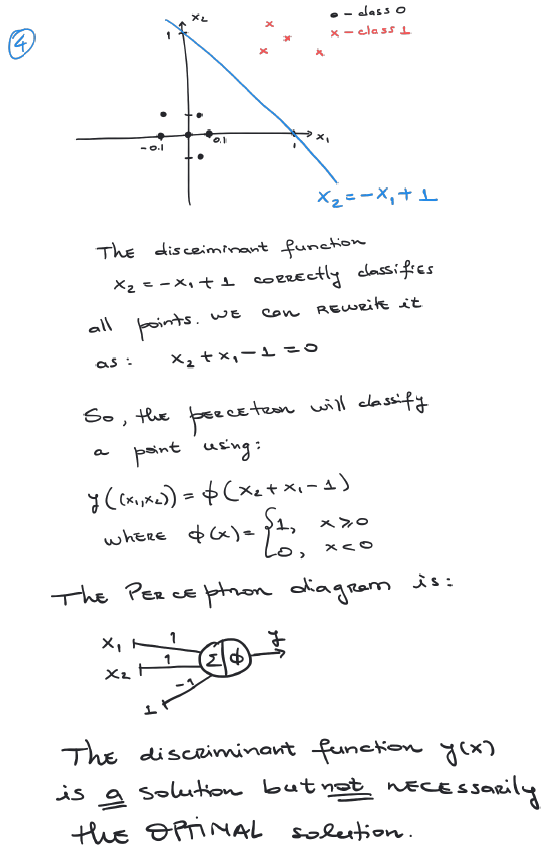

In [28]:
Image('Q4-2.png', width=700)